# The Impact of Policy Changes on Bond Yields and Economic Stability

This project investigated the effects of monetary policy changes on bond yields, economic indicators, and financial stability from 1990 to 2025. By analyzing 49 significant policy events, the study identified key relationships between interest rate changes, economic performance, and market conditions.

#### Dataset Overview
- Timeframe: January 1990 – March 2025
- Observations: 423 data points
- Indicators: Includes short-term and long-term interest rates (e.g., 3-Month, 10-Year), economic measures (e.g., CPI, Unemployment, Industrial Production), and financial metrics (e.g., USD/EUR exchange rate, Housing Starts).
- Significant Events: 49 major policy events identified.

#### Objectives

1. Main Purpose: This code analyzes the impact of significant changes in the Federal Reserve's policy interest rate (FedRate) on bond yields and key economic indicators (e.g., unemployment, inflation).

2. Statistical Analysis: It uses t-tests to assess whether the observed changes in these indicators are statistically significant after a policy change.

3. Visualization: The code generates visualizations to help understand the relationship between policy rate changes and economic impacts.

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import ttest_ind
import pandas_datareader as pdr
import warnings
warnings.filterwarnings('ignore')

# Set up visualization defaults
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configure FRED API key
import os
os.environ["FRED_API_KEY"] = "6693788a99e471f7b186f3a8fb13a047"

## Fetching Data

In [3]:
def fetch_fred_data(series_dict, start_date='1990-01-01', end_date=None, freq=None):
    """
    Fetch data from FRED with proper frequency alignment
    
    Parameters:
    -----------
    series_dict : dict
        Dictionary mapping FRED series IDs to desired column names
    start_date : str
        Start date for data retrieval
    end_date : str
        End date for data retrieval (optional)
    freq : str
        Frequency to resample data to (e.g., 'M' for monthly, 'Q' for quarterly)
        
    Returns:
    --------
    DataFrame with properly aligned time series data
    """
    try:
        # Fetch the data
        data = pdr.get_data_fred(
            list(series_dict.keys()), 
            start=start_date,
            end=end_date
        )
        
        # Rename columns
        data = data.rename(columns=series_dict)
        
        # Resample if frequency is specified
        if freq is not None:
            if freq.upper() == 'M':
                # For monthly, take end-of-month values
                data = data.resample('M').last()
            elif freq.upper() == 'Q':
                # For quarterly, take end-of-quarter values
                data = data.resample('Q').last()
        
        return data
    
    except Exception as e:
        print(f"Error fetching FRED data: {e}")
        return None

## Analyzing Policy Impacts

This is the core function that performs the analysis of how policy rate changes (like the Federal Reserve's interest rate hikes or cuts) impact yields and other economic indicators.

- It calculates the policy rate change (Policy_Change) by looking at the difference between successive values of the Federal Funds Rate (FedRate).
- The function then identifies significant policy events where the change in the Fed rate is above a minimum threshold (e.g., 0.25%).
- It separates these events into rate hikes (increases) and rate cuts (decreases).
- For each event, it defines a "before" and "after" window (e.g., 3 months before and after the rate change) to analyze the impact on bond yields and economic indicators.
- It calculates the average values of each indicator before and after the event and computes the change (both in raw terms and percentage).
- The function aggregates these results to compute summary statistics, including statistical significance (using t-tests) to determine if the observed changes are meaningful.

In [4]:
def analyze_policy_impacts(data, policy_col='FedRate', yield_cols=None, 
                          window_size=3, min_change=0.25):
    """
    Analyze how policy changes impact yields and economic indicators
    
    Parameters:
    -----------
    data : DataFrame
        Time series data with policy rates and yields
    policy_col : str
        Column name for policy rate (e.g., 'FedRate')
    yield_cols : list
        List of yield/economic columns to analyze
    window_size : int
        Number of periods before/after to analyze (e.g., 3 months or quarters)
    min_change : float
        Minimum policy rate change to consider significant
        
    Returns:
    --------
    Dictionary of results and DataFrame of event data for visualization
    """
    if yield_cols is None:
        yield_cols = [col for col in data.columns if col != policy_col]
    
    # Calculate policy rate changes
    data['Policy_Change'] = data[policy_col].diff()
    
    # Identify significant policy shifts
    policy_events = data[abs(data['Policy_Change']) >= min_change].copy()
    
    # If no events meet criteria, try looser threshold
    if len(policy_events) < 3:
        min_change = min_change / 2
        policy_events = data[abs(data['Policy_Change']) >= min_change].copy()
        print(f"Too few events found, reduced threshold to {min_change}")
    
    print(f"Found {len(policy_events)} significant policy events")
    
    # Classify events as hikes or cuts
    policy_events['Event_Type'] = policy_events['Policy_Change'].apply(
        lambda x: 'Rate Hike' if x > 0 else 'Rate Cut')
    
    # Create event windows for analysis
    event_windows = []
    impact_stats = {'Rate Hike': {}, 'Rate Cut': {}}
    
    for event_date, row in policy_events.iterrows():
        # Define before/after periods
        before_start = event_date - pd.DateOffset(months=window_size*3)
        before_end = event_date - pd.DateOffset(days=1)
        after_start = event_date
        after_end = event_date + pd.DateOffset(months=window_size*3)
        
        # Get data before/after event
        before_data = data.loc[before_start:before_end]
        after_data = data.loc[after_start:after_end]
        
        # Skip if we don't have enough data points
        if len(before_data) < window_size or len(after_data) < window_size:
            continue
            
        # Calculate changes for each yield/economic indicator
        event_type = row['Event_Type']
        
        for col in yield_cols:
            # Get average values before/after
            before_avg = before_data[col].mean()
            after_avg = after_data[col].mean()
            
            # Calculate change
            change = after_avg - before_avg
            pct_change = change / before_avg * 100 if before_avg != 0 else np.nan
            
            # Collect event data for visualization
            event_data = {
                'Event_Date': event_date,
                'Event_Type': event_type,
                'Indicator': col,
                'Before_Value': before_avg,
                'After_Value': after_avg,
                'Change': change,
                'Pct_Change': pct_change,
                'Policy_Change': row['Policy_Change']
            }
            event_windows.append(event_data)
            
            # Aggregate statistics by event type
            if col not in impact_stats[event_type]:
                impact_stats[event_type][col] = {
                    'before_values': [],
                    'after_values': [],
                    'changes': [],
                    'pct_changes': []
                }
            
            stats = impact_stats[event_type][col]
            stats['before_values'].append(before_avg)
            stats['after_values'].append(after_avg)
            stats['changes'].append(change)
            stats['pct_changes'].append(pct_change)
    
    # Convert event windows to DataFrame
    event_df = pd.DataFrame(event_windows)
    
    # Calculate summary statistics
    for event_type in impact_stats:
        for col in impact_stats[event_type]:
            stats = impact_stats[event_type][col]
            if len(stats['changes']) > 0:
                # Calculate means
                stats['mean_before'] = np.mean(stats['before_values'])
                stats['mean_after'] = np.mean(stats['after_values'])
                stats['mean_change'] = np.mean(stats['changes'])
                stats['mean_pct_change'] = np.mean([p for p in stats['pct_changes'] if not np.isnan(p)])
                
                # Calculate statistical significance
                if len(stats['before_values']) > 1 and len(stats['after_values']) > 1:
                    t_stat, p_value = ttest_ind(stats['after_values'], stats['before_values'])
                    stats['t_statistic'] = t_stat
                    stats['p_value'] = p_value
                    stats['significant'] = p_value < 0.05
    
    return impact_stats, event_df

## Visualizing Results

This function visualizes the results of the policy analysis.

It creates two types of plots:

- Average impact by indicator and event type: This bar chart shows the mean change in economic indicators (like bond yields) before and after rate hikes and cuts.
- Relationship between policy change magnitude and impact: This scatter plot shows how the magnitude of policy rate changes relates to the impact on various indicators.

In [5]:
def plot_policy_impacts(event_df, impact_stats):
    """Plot the impact of policy changes on yields and economic indicators"""
    
    # Plot 1: Average impact by indicator and event type
    plt.figure(figsize=(14, 8))
    
    # Prepare data for plotting
    plot_data = []
    for event_type in ['Rate Hike', 'Rate Cut']:
        if event_type in impact_stats:
            for indicator, stats in impact_stats[event_type].items():
                if 'mean_change' in stats:
                    plot_data.append({
                        'Event_Type': event_type,
                        'Indicator': indicator,
                        'Mean_Change': stats['mean_change'],
                        'Significant': stats.get('significant', False)
                    })
    
    if not plot_data:
        print("Not enough data for visualization")
        return
        
    plot_df = pd.DataFrame(plot_data)
    
    # Create subplot for each event type
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, event_type in enumerate(['Rate Hike', 'Rate Cut']):
        event_data = plot_df[plot_df['Event_Type'] == event_type]
        
        if len(event_data) > 0:
            # Sort by absolute magnitude of impact
            event_data = event_data.sort_values('Mean_Change', key=abs)
            
            # Create color mapping for significance
            colors = event_data['Significant'].map({True: 'darkblue', False: 'lightblue'})
            
            # Plot horizontal bar chart
            ax = axes[i]
            ax.barh(event_data['Indicator'], event_data['Mean_Change'], color=colors)
            ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
            ax.set_title(f'Average Impact of {event_type}s')
            ax.set_xlabel('Change')
            
            # Add text for statistical significance
            for j, (idx, row) in enumerate(event_data.iterrows()):
                if row['Significant']:
                    ax.text(0, j, ' *', ha='center', va='center', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Relationship between policy change magnitude and impact
    plt.figure(figsize=(14, 8))
    
    # Filter to significant indicators
    sig_indicators = []
    for event_type in impact_stats:
        for indicator, stats in impact_stats[event_type].items():
            if stats.get('significant', False):
                sig_indicators.append(indicator)
    
    if not sig_indicators:
        # If no significant indicators, take top 3 by absolute change
        all_changes = []
        for event_type in impact_stats:
            for indicator, stats in impact_stats[event_type].items():
                if 'mean_change' in stats:
                    all_changes.append((indicator, abs(stats['mean_change'])))
        
        sig_indicators = [x[0] for x in sorted(all_changes, key=lambda x: x[1], reverse=True)[:3]]
    
    # For each significant indicator, plot relationship with policy change
    for i, indicator in enumerate(sig_indicators):
        indicator_data = event_df[event_df['Indicator'] == indicator]
        
        plt.subplot(2, 2, i+1)
        sns.scatterplot(x='Policy_Change', y='Change', 
                      hue='Event_Type', data=indicator_data)
        
        # Add regression line
        if len(indicator_data) >= 3:  # Need at least 3 points for regression
            sns.regplot(x='Policy_Change', y='Change', 
                      data=indicator_data, scatter=False, ci=None)
        
        plt.title(f'Impact on {indicator}')
        plt.xlabel('Policy Rate Change')
        plt.ylabel(f'{indicator} Change')
        plt.axhline(0, color='black', linestyle='-', alpha=0.3)
        plt.axvline(0, color='black', linestyle='-', alpha=0.3)
        
        # Stop after 4 indicators
        if i >= 3:
            break
    
    plt.tight_layout()
    plt.show()


# Define data sources with more granular yield curve data
yield_series = {
    'DGS3MO': '3_Month',
    'DGS2': '2_Year',
    'DGS5': '5_Year',
    'DGS10': '10_Year',
    'DGS30': '30_Year',
    'T10Y2Y': '10Y_2Y_Spread',  # 10-year minus 2-year spread (direct from FRED)
    'T10Y3M': '10Y_3M_Spread'   # 10-year minus 3-month spread (direct from FRED)
}

macro_series = {
    'FEDFUNDS': 'FedRate',
    'UNRATE': 'Unemployment',
    'CPIAUCSL': 'CPI',
    'INDPRO': 'Industrial_Production',
    'UMCSENT': 'Consumer_Sentiment',
    'HOUST': 'Housing_Starts',
    'DEXUSEU': 'USD_EUR'  # Exchange rate: US dollars to Euros
}

## Running the Full Analysis

This function runs the complete macroeconomic policy analysis by:

- Fetching the relevant yield and macroeconomic data.
- Combining and cleaning the data.
- Analyzing the impacts of significant policy changes using analyze_policy_impacts().
- Printing a summary of results with statistical significance.

Fetching data from FRED...
Combined dataset has 423 observations from 1990-01 to 2025-03
Available indicators: 3_Month, 2_Year, 5_Year, 10_Year, 30_Year, 10Y_2Y_Spread, 10Y_3M_Spread, FedRate, Unemployment, CPI, Industrial_Production, Consumer_Sentiment, Housing_Starts, USD_EUR

Analyzing policy impacts...
Found 49 significant policy events

--- POLICY IMPACT SUMMARY ---

Rate Hike Effects:
----------------------------------------
Housing_Starts  -161.5244 *
  Before: 1607.1185, After: 1445.5941
  (p-value: 0.0009)
3_Month         +2.0648 *
  Before: 2.9821, After: 5.0470
  (p-value: 0.0008)
10Y_3M_Spread   -1.5132 *
  Before: 1.5206, After: 0.0073
  (p-value: 0.0002)
10Y_2Y_Spread   -0.6424 *
  Before: 0.4761, After: -0.1662
  (p-value: 0.0022)
USD_EUR         +nan 
  Before: nan, After: nan
  (p-value: nan)
CPI             +7.8100 
  Before: 220.6050, After: 228.4150
  (p-value: 0.7568)
Industrial_Production +1.5485 
  Before: 90.5482, After: 92.0966
  (p-value: 0.7687)
2_Year       

<Figure size 1400x800 with 0 Axes>

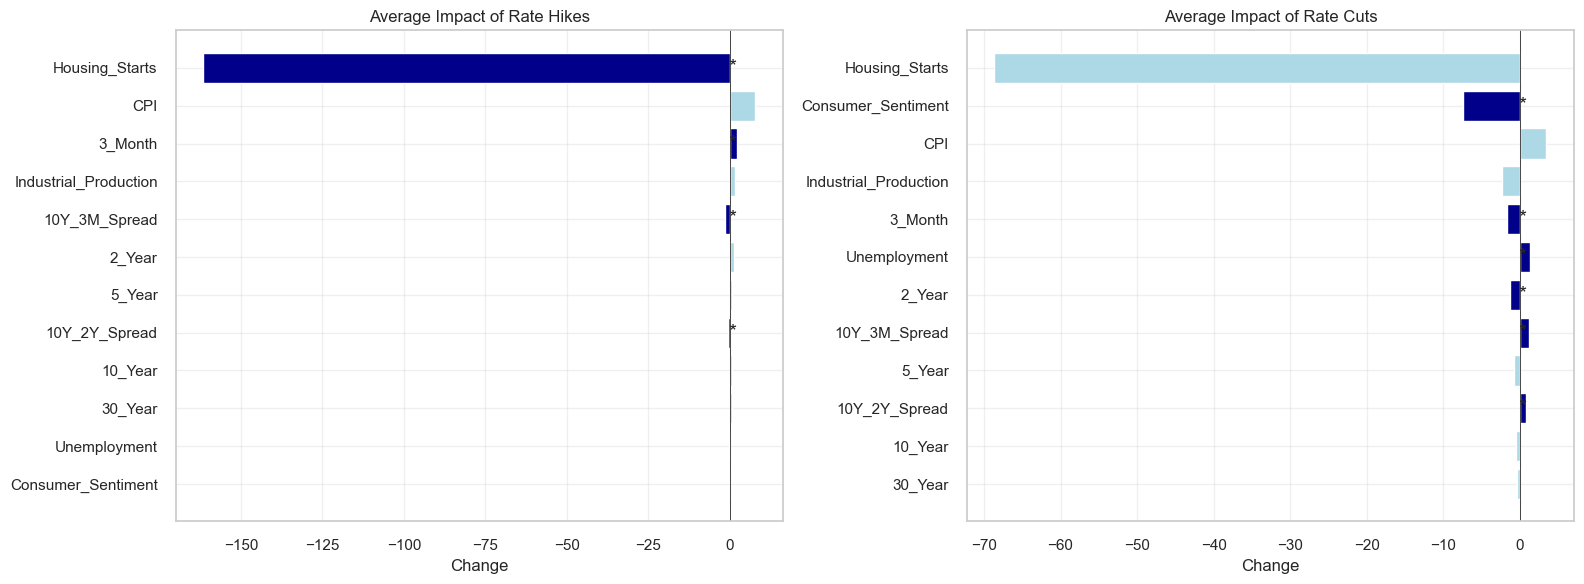

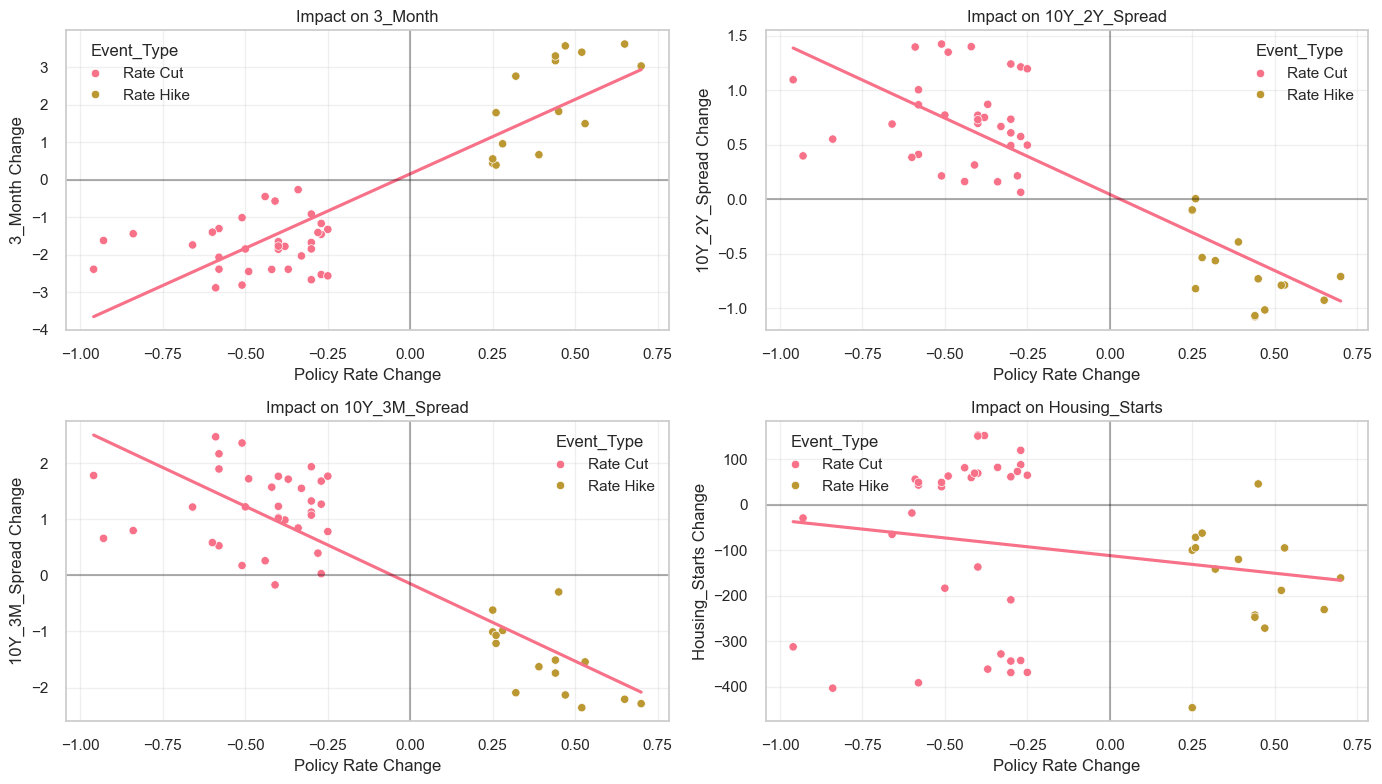


--- YIELD CURVE ANALYSIS ---
Yield Curve Inversion Periods (10Y-2Y):
  Inversion began: 1998-06
  Inversion ended: 1998-07
  Inversion began: 2000-02
  Inversion ended: 2000-12
  Inversion began: 2005-12
  Inversion ended: 2006-03
  Inversion began: 2006-06
  Inversion ended: 2006-07
  Inversion began: 2006-08
  Inversion ended: 2007-03
  Inversion began: 2007-05
  Inversion ended: 2007-06
  Inversion began: 2022-07
  Inversion ended: 2024-08

Yield Curve Inversion Periods (10Y-3M):
  Inversion began: 2000-07
  Inversion ended: 2001-01
  Inversion began: 2006-02
  Inversion ended: 2006-03
  Inversion began: 2006-07
  Inversion ended: 2007-05
  Inversion began: 2007-07
  Inversion ended: 2007-08
  Inversion began: 2019-05
  Inversion ended: 2019-10
  Inversion began: 2020-01
  Inversion ended: 2020-03
  Inversion began: 2022-10
  Inversion ended: 2024-12
  Inversion began: 2025-02


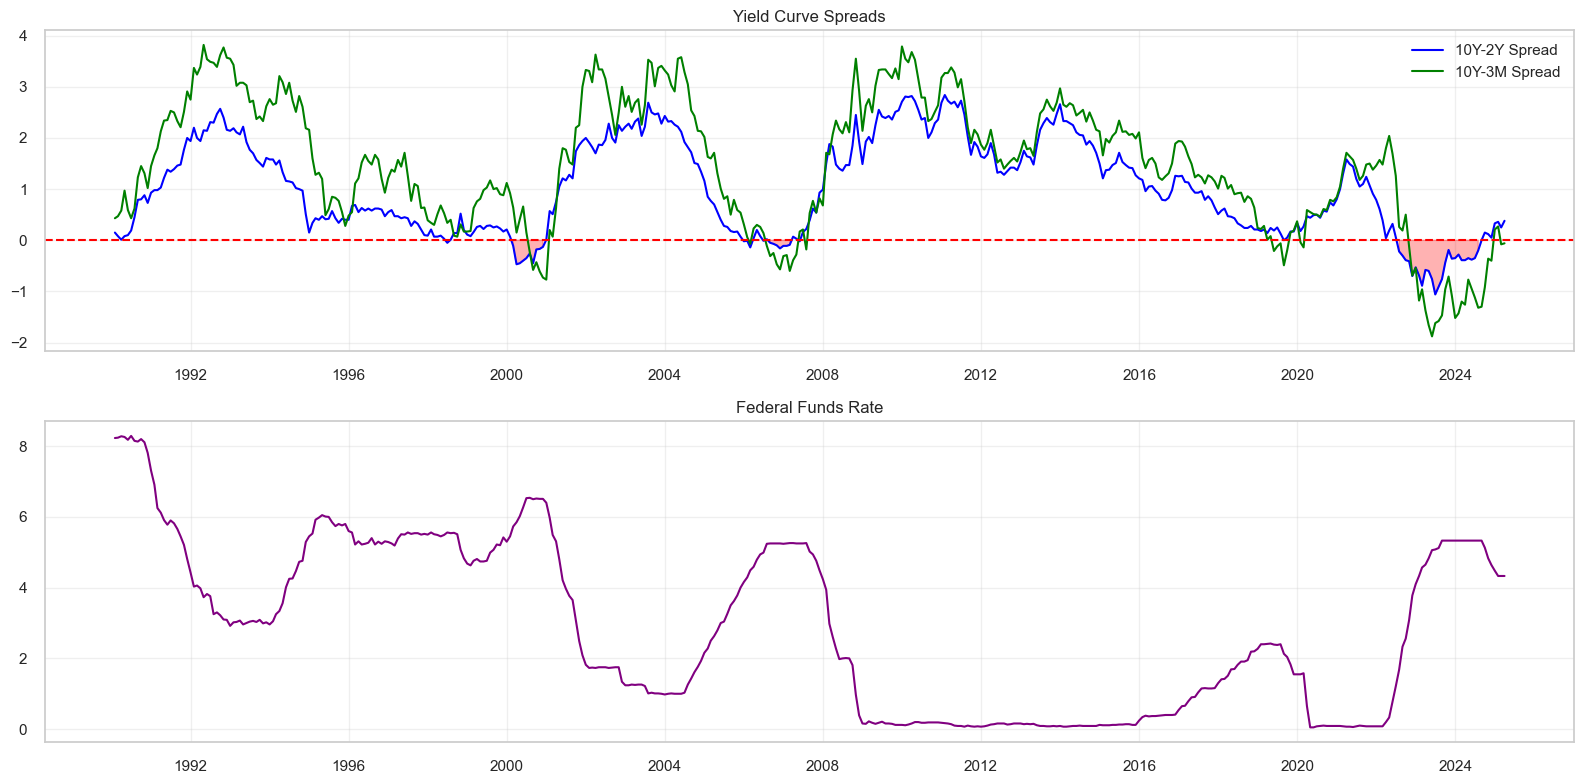


Analyzing lead/lag relationships between policy rates and yield curve...


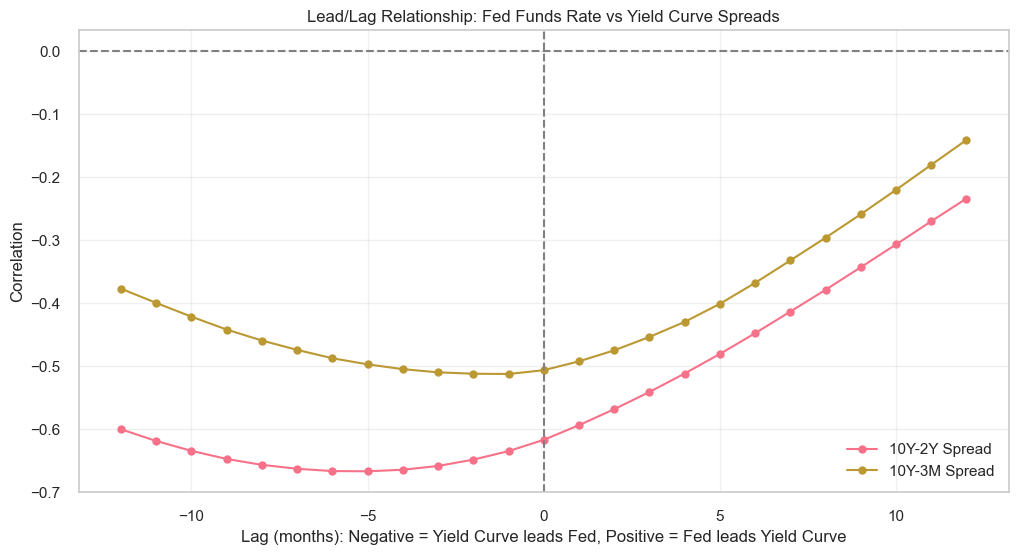


Analysis complete! Results saved to 'policy_impact_events.csv'


In [6]:
# Main analysis function
def run_macro_policy_analysis():
    """Run the complete macroeconomic policy impact analysis"""
    
    print("Fetching data from FRED...")
    # Get monthly data for better alignment
    yields = fetch_fred_data(yield_series, start_date='1990-01-01', freq='M')
    macro = fetch_fred_data(macro_series, start_date='1990-01-01', freq='M')
    
    # Combine datasets and handle missing values
    if yields is not None and macro is not None:
        combined = yields.join(macro)
        
        # Forward fill for short gaps in data
        combined = combined.ffill(limit=2)
        
        # Drop rows with excessive missing data
        combined = combined.dropna(thresh=len(combined.columns) - 3)
        
        print(f"Combined dataset has {len(combined)} observations from {combined.index.min().strftime('%Y-%m')} to {combined.index.max().strftime('%Y-%m')}")
        print(f"Available indicators: {', '.join(combined.columns)}")
        
        # Run policy impact analysis
        print("\nAnalyzing policy impacts...")
        yield_indicators = [col for col in yields.columns]
        macro_indicators = [col for col in macro.columns if col != 'FedRate']
        
        results, event_data = analyze_policy_impacts(
            combined, 
            policy_col='FedRate',
            yield_cols=yield_indicators + macro_indicators,
            window_size=3,  # 3 months before/after
            min_change=0.25  # 25 basis points minimum change
        )
        
        # Display summary of results
        print("\n--- POLICY IMPACT SUMMARY ---")
        for event_type in results:
            print(f"\n{event_type} Effects:")
            print("-" * 40)
            
            # Sort indicators by statistical significance and magnitude of change
            sorted_indicators = []
            for indicator, stats in results[event_type].items():
                if 'mean_change' in stats:
                    significance = stats.get('p_value', 1.0)
                    abs_change = abs(stats.get('mean_change', 0))
                    sorted_indicators.append((indicator, significance, abs_change))
            
            sorted_indicators.sort(key=lambda x: (x[1] > 0.05, -x[2]))
            
            # Display results
            for indicator, significance, _ in sorted_indicators:
                stats = results[event_type][indicator]
                sig_marker = "*" if stats.get('significant', False) else ""
                
                print(f"{indicator:<15} {stats['mean_change']:+.4f} {sig_marker}")
                print(f"  Before: {stats['mean_before']:.4f}, After: {stats['mean_after']:.4f}")
                if 'p_value' in stats:
                    print(f"  (p-value: {stats['p_value']:.4f})")
        
        # Plot results
        if len(event_data) > 0:
            print("\nGenerating visualizations...")
            plot_policy_impacts(event_data, results)
        
        # Analyze yield curve specifically
        if '10Y_2Y_Spread' in combined.columns and '10Y_3M_Spread' in combined.columns:
            print("\n--- YIELD CURVE ANALYSIS ---")
            yield_curve = combined[['FedRate', '10Y_2Y_Spread', '10Y_3M_Spread']].copy()
            
            # Identify inversions
            yield_curve['2Y_Inversion'] = yield_curve['10Y_2Y_Spread'] < 0
            yield_curve['3M_Inversion'] = yield_curve['10Y_3M_Spread'] < 0
            
            # Find periods of inversion
            changes_2y = yield_curve['2Y_Inversion'].diff().fillna(0) != 0
            changes_3m = yield_curve['3M_Inversion'].diff().fillna(0) != 0
            
            inversion_periods_2y = yield_curve[changes_2y]
            inversion_periods_3m = yield_curve[changes_3m]
            
            print("Yield Curve Inversion Periods (10Y-2Y):")
            for date, row in inversion_periods_2y.iterrows():
                if row['2Y_Inversion']:
                    print(f"  Inversion began: {date.strftime('%Y-%m')}")
                else:
                    print(f"  Inversion ended: {date.strftime('%Y-%m')}")
            
            print("\nYield Curve Inversion Periods (10Y-3M):")
            for date, row in inversion_periods_3m.iterrows():
                if row['3M_Inversion']:
                    print(f"  Inversion began: {date.strftime('%Y-%m')}")
                else:
                    print(f"  Inversion ended: {date.strftime('%Y-%m')}")
            
            # Plot yield curve over time with Fed rate
            plt.figure(figsize=(16, 8))
            
            plt.subplot(2, 1, 1)
            plt.plot(yield_curve.index, yield_curve['10Y_2Y_Spread'], 
                    label='10Y-2Y Spread', color='blue')
            plt.plot(yield_curve.index, yield_curve['10Y_3M_Spread'], 
                    label='10Y-3M Spread', color='green')
            plt.axhline(0, color='red', linestyle='--')
            plt.fill_between(yield_curve.index, 0, yield_curve['10Y_2Y_Spread'], 
                           where=yield_curve['10Y_2Y_Spread'] < 0, color='red', alpha=0.3)
            plt.legend()
            plt.title('Yield Curve Spreads')
            
            plt.subplot(2, 1, 2)
            plt.plot(yield_curve.index, yield_curve['FedRate'], label='Fed Funds Rate', color='purple')
            plt.title('Federal Funds Rate')
            plt.tight_layout()
            plt.show()
            
            # Analyze lead/lag relationship
            print("\nAnalyzing lead/lag relationships between policy rates and yield curve...")
            lag_periods = range(-12, 13)  # -12 to +12 months
            
            corr_2y = [yield_curve['FedRate'].corr(yield_curve['10Y_2Y_Spread'].shift(-lag)) 
                     for lag in lag_periods]
            corr_3m = [yield_curve['FedRate'].corr(yield_curve['10Y_3M_Spread'].shift(-lag)) 
                     for lag in lag_periods]
            
            plt.figure(figsize=(12, 6))
            plt.plot(lag_periods, corr_2y, 'o-', label='10Y-2Y Spread')
            plt.plot(lag_periods, corr_3m, 'o-', label='10Y-3M Spread')
            plt.axvline(0, color='gray', linestyle='--')
            plt.axhline(0, color='gray', linestyle='--')
            plt.xlabel('Lag (months): Negative = Yield Curve leads Fed, Positive = Fed leads Yield Curve')
            plt.ylabel('Correlation')
            plt.title('Lead/Lag Relationship: Fed Funds Rate vs Yield Curve Spreads')
            plt.legend()
            plt.grid(True)
            plt.show()
        
        # Save results for further analysis
        event_data.to_csv('policy_impact_events.csv', index=False)
        print("\nAnalysis complete! Results saved to 'policy_impact_events.csv'")
        
    else:
        print("Failed to retrieve data. Please check your API key and internet connection.")

# Run the analysis
run_macro_policy_analysis()

### Key Findings

**Rate hikes strongly impact housing, short-term rates, and the yield curve but have limited short-term effects on inflation and employment.**

- Housing Starts significantly decreased (p = 0.0009), meaning higher rates slowed housing activity.
- Short-term rates (3-Month) significantly increased (p = 0.0008), as expected with rate hikes.
- Yield Curve Spread (10Y-3M, 10Y-2Y) narrowed (p < 0.01), often a sign of economic slowdown or recession risk.
- Long-term rates (10-Year, 30-Year) increased slightly, but changes were not statistically significant.
- CPI and Industrial Production showed mild increases but were not significant, meaning rate hikes did not strongly impact inflation or production.
- Unemployment slightly decreased, but not significantly.
- Consumer Sentiment was largely unchanged.


**Rate cuts tend to happen during recessions, causing unemployment to rise but steepening the yield curve.**

- Consumer Sentiment significantly declined (p = 0.0083), meaning that rate cuts often follow economic distress.
- Unemployment significantly increased (p = 0.0000), confirming rate cuts tend to occur during economic slowdowns.
- Short-term rates (3-Month, 2-Year) significantly fell (p < 0.01), showing the intended effect of easing monetary policy.
- Yield Curve Spread (10Y-3M, 10Y-2Y) widened (p < 0.01), indicating markets anticipate economic recovery.
- Housing Starts and Industrial Production declined, but changes were not significant.
- CPI (Inflation) barely changed.
  
**Yield curve inversions are strong leading indicators of recessions.**

- The yield curve inverted multiple times, with notable periods in 2000, 2006-07, 2019, and 2022-2024, aligning with major economic downturns (e.g., Dot-com crash, Global Financial Crisis, COVID-19).
- The most recent inversion (2022-2024) suggests recession concerns in the past few years.

## Conclusion

This analysis confirms that monetary policy shifts have significant and measurable effects on financial markets. Yield curve inversions remain a strong predictor of economic downturns, while housing markets and employment are particularly sensitive to rate changes. Although inflation and industrial production showed less immediate response, the long-term effects warrant further study.

### Future Directions

1. Expanding the analysis to include fiscal policy effects.
2. Examining global economic conditions and their influence on monetary policy outcomes.
3. Implementing machine learning models to forecast policy-driven economic shifts.

This study underscores the critical role of central bank decisions in shaping financial stability, offering valuable insights for policymakers, investors, and economists. 